In [1]:
import torch

from rl4co.envs import TSPEnv, PDPEnv, RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import random
def create_connected_graph(num_nodes):
    # Create an adjacency matrix initialized to zero
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Ensure the graph is connected by adding a spanning tree
    for i in range(1, num_nodes):
        # Connect each node to a previous random node to ensure connectivity
        j = random.randint(0, i-1)
        adjacency_matrix[i][j] = 1
        adjacency_matrix[j][i] = 1  # For undirected graph, make the connection bidirectional

    # Optionally add more edges to make the graph denser
    additional_edges = 20  # You can vary this number to add more or fewer edges
    while additional_edges > 0:
        i = random.randint(0, num_nodes-1)
        j = random.randint(0, num_nodes-1)
        if i != j and adjacency_matrix[i][j] == 0:
            adjacency_matrix[i][j] = 1
            adjacency_matrix[j][i] = 1  # For undirected graph
            additional_edges -= 1

    # import matplotlib.pyplot as plt
    # plt.imshow(adjacency_matrix, cmap='gray', interpolation='none')
    # plt.show()
    
    return adjacency_matrix

end_node:  tensor([11, 11])
first_node:  tensor([0, 0])
action:  tensor([18,  1])
done:  tensor([[False],
        [False]])
action:  tensor([0, 4])
done:  tensor([False, False])
action:  tensor([18, 17])
done:  tensor([False, False])
action:  tensor([0, 4])
done:  tensor([False, False])
action:  tensor([18, 14])
done:  tensor([False, False])
action:  tensor([11,  2])
done:  tensor([False, False])
action:  tensor([11, 14])
done:  tensor([ True, False])
action:  tensor([11,  2])
done:  tensor([ True, False])
action:  tensor([11, 14])
done:  tensor([ True, False])
action:  tensor([11,  4])
done:  tensor([ True, False])
action:  tensor([11,  6])
done:  tensor([ True, False])
action:  tensor([11, 18])
done:  tensor([ True, False])
action:  tensor([11,  1])
done:  tensor([ True, False])
action:  tensor([11, 16])
done:  tensor([ True, False])
action:  tensor([11, 12])
done:  tensor([ True, False])
action:  tensor([11,  9])
done:  tensor([ True, False])
action:  tensor([11, 10])
done:  tensor(

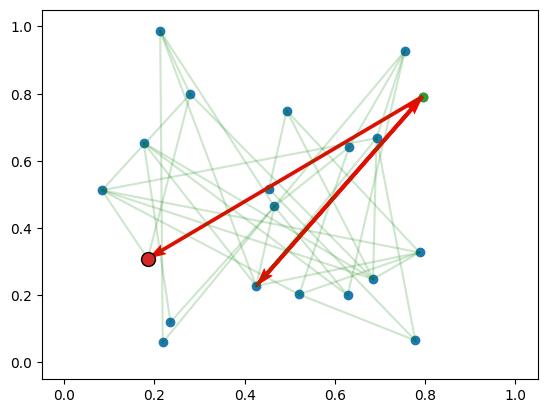

In [16]:
from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.pylogger import get_pylogger
log = get_pylogger(__name__)

def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    """Reset the environment to the initial state"""
    # If no TensorDict is provided, generate a new one
    init_locs = td["locs"] if td is not None else None
    init_edges = td["edges"] if td is not None else None
    # If no batch_size is provided, use the batch_size of the initial locations
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    # If no device is provided, use the device of the initial locations
    device = init_locs.device if init_locs is not None else self.device 
    self.to(device)
    # If no initial locations are provided, generate new ones
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    if init_edges is None:
        init_edges = self.generate_data(batch_size=batch_size).to(device)["edges"]

    # If batch_size is an integer, convert it to a list
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Get the number of locations
    num_loc = init_locs.shape[-2]

    # Initialize a start and end node
    first_node = torch.zeros((batch_size), dtype=torch.int64, device=device)
    # Initialize the end node to a random node until it is unequal to the start node
    while True:
        end_node = torch.randint(0, num_loc, (batch_size), device=device)
        if not torch.any(torch.eq(first_node, end_node)):
            break

    print("end_node: ", end_node)
    print("first_node: ", first_node)
    
    # Initialize the action mask to the neighbors of the start node
    batch_indices = torch.arange(len(first_node))
    available = init_edges[batch_indices, first_node]
    
    # Initialize the index of the current node 
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "edges": init_edges,
            "first_node": first_node,
            "current_node": first_node,
            "end_node": end_node,
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
        },
        batch_size=batch_size,
    )

def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]

    # output visiting node
    first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Mark the current node as visited
    available = get_action_mask(self, td)

    # Create a tensor of batch indices
    # batch_indices = torch.arange(len(current_node))

    # Use advanced indexing to get the neighbors for each batch
    # neighbors = td["edges"][batch_indices, current_node]

    # Update the action_mask to only include the current node's neighbors
    # available = available & neighbors
 
    done = current_node == td["end_node"]
    # done = torch.sum(td["action_mask"], dim=-1) == 0

    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            # "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            "action_mask": available,
            "reward": reward,
            "done": done,
        },
    )
    return td

def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Get the current node
    current_node = td["action"]

    # Create a tensor of batch indices
    batch_indices = torch.arange(len(current_node))

    # Use advanced indexing to get the neighbors for each batch
    neighbors = td["edges"][batch_indices, current_node]

    # Mask the neighbors to only include current node if terminated

    # Update the action_mask to only include the current node's neighbors
    # available = td["action_mask"] & neighbors

    return neighbors

def get_reward(self, td, actions) -> TensorDict:
    # Reward the agent based on the length of the path from the start node to the end
    locs_ordered = gather_by_index(td["locs"], actions)

    # print("reward: ", reward)
    return -get_tour_length(locs_ordered)

def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            low=self.min_loc,
            high=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        start_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        end_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        low=0,
        high=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    # Generate random locations for the nodes
    locs = (
        torch.rand((*batch_size, self.num_loc, 2), generator=self.rng)
        * (self.max_loc - self.min_loc)
        + self.min_loc

    )
    # Generate a random adjaceny matrix for the edges
    edges = torch.zeros((*batch_size, self.num_loc, self.num_loc), dtype=torch.bool)
    for i in range(edges.shape[0]):
        matrix = create_connected_graph(self.num_loc)
        edges[i] = torch.tensor(matrix, dtype=torch.bool)
    return TensorDict({"locs": locs, "edges": edges}, batch_size=batch_size)

def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]
        
    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        a_locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    # locs = torch.cat((locs, locs[0:1]))
    x, y = a_locs[:, 0], a_locs[:, 1]

    # Plot the visited nodes
    ax.scatter(locs[:, 0], locs[:, 1], color="tab:blue")

    # Highlight the start node in green
    ax.scatter(x[0], y[0], color="tab:green")

    # Highlight the end node in red
    ax.scatter(x[-1], y[-1], color="tab:red")

    # Plot the edges
    edges = td["edges"]
    x_i, y_i = locs[:, 0], locs[:, 1]
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i, j]:
                ax.plot([x_i[i], x_i[j]], [y_i[i], y_i[j]], color='g', alpha=0.1)

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="r", alpha=1.0
    )

    # Highlight the last action
    ax.scatter(x[-1], y[-1], color="tab:red", s=100, edgecolors="black", zorder=10)

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

class SPPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)

    _reset = _reset
    _step = _step
    get_reward = get_reward
    # check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

def greedy(logprobs, mask=None):
    """Select the action with the highest probability."""
    # [BS], [BS]
    selected = logprobs.argmax(dim=-1)
    if mask is not None:
        assert (
            not (~mask).gather(1, selected.unsqueeze(-1)).data.any()
        ), "infeasible action selected"

    return selected

def rollout(env, td, policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0
    done_mask = torch.zeros(td.batch_size, dtype=torch.bool, device=td.device)

    while not td["done"].all():
        # Select non-done actions
        td_masked = td.masked_select(~done_mask)

        # Apply the policy to the non-done actions
        td_masked = policy(td_masked)

        # Update the action tensor
        action = torch.where(~done_mask, td_masked["action"], td["current_node"])

        # Update td with actions
        td.set("action", action)
        actions.append(td["action"])
        
        print("action: ", action)
        print("done: ", td["done"])

        # Perform the next step
        td = env.step(td)["next"]
        
        # Update the done mask
        done_mask |= td["done"]

        steps += 1
        if steps > max_steps:
            log.info("Max steps reached")
            break
    return (
        env.get_reward(td, torch.stack(actions, dim=1)),
        td,
        torch.stack(actions, dim=1),
    )

# from rl4co.utils.decoding import rollout, random_policy

batch_size = 2

env = SPPEnv(num_loc=20)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

In [17]:
env = SPPEnv(num_loc=20)

policy = AttentionModelPolicy(env.name, 
                              embedding_dim=128, 
                              num_encoder_layers=3, 
                              num_heads=8,)

model = AttentionModel(env, baseline="rollout",
                       policy=policy,
                       train_data_size=100_000,
                       val_data_size=10_000,
                       optimizer_kwargs= {"lr": 1e-4},)

/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


end_node:  tensor([ 8,  8, 16])
first_node:  tensor([0, 0, 0])
Problem 1 | Cost: 171.703
Problem 2 | Cost: 178.985
Problem 3 | Cost: 163.702


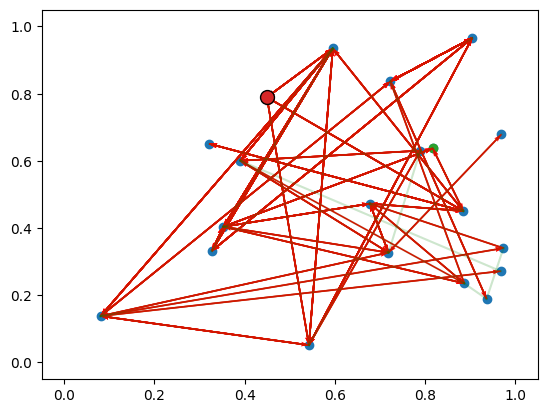

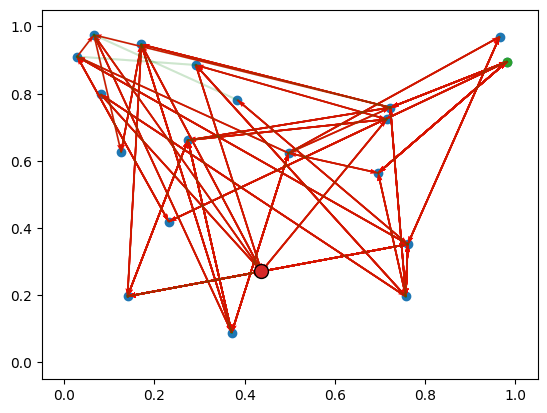

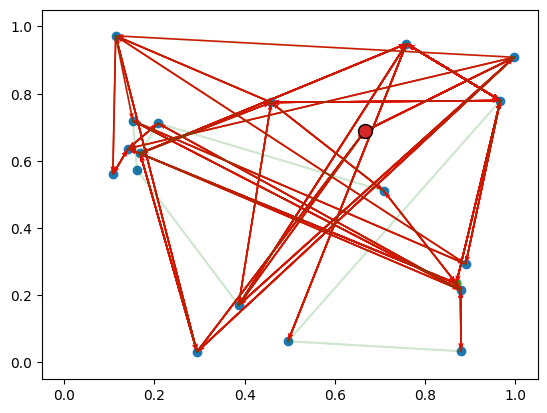

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [149]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")